In [97]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.float_format', '{:.2f}'.format)
fig_path = '../figures/'

In [98]:
'''
To do list:
# 1. What distances are most popular between men and women
# 2. How many races occur over time
# 3. Where do the most racers come from
4. Most prominent age categories when compared to distance/length
5. How many female racers achieved 1st place overall.
# 6. Who are the fastest athletes for the top 10 or so distances
# 7. What athletes win the most races
'''

'\nTo do list:\n# 1. What distances are most popular between men and women\n# 2. How many races occur over time\n# 3. Where do the most racers come from\n4. Most prominent age categories when compared to distance/length\n5. How many races go over 1 day. WORKING ON IT\n# 6. Who are the fastest athletes for the top 10 or so distances\n# 7. What athletes win the most races\n'

In [122]:
df = pd.read_csv('../data/ultra_marathons_data_cleaned.csv')
try:
    df.drop('Unnamed: 0', axis=1, inplace=True)
except:
    pass
df['fastest_time'] = pd.to_timedelta(df['fastest_time'], errors = 'coerce')
df.head()

C:\Users\OMEN\AppData\Local\Temp\ipykernel_14764\1987717982.py:1: DtypeWarning:

Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.



,year_of_event,event_name,distance_or_length,no_of_finishers,total_distance,athlete_club,athlete_country,birth_year,gender,age_category,average_speed,athlete_id,race_metric,start_date,end_date,fastest_time
0,2018,Selva Costera (CHI),50.00,22,0.00,Tnfrc,CHI,1978,M,M35,10.286,0,km,2018-01-06,2018-01-06,0 days 04:51:39
1,2018,Selva Costera (CHI),50.00,22,0.00,Roberto Echeverría,CHI,1981,M,M35,9.501,1,km,2018-01-06,2018-01-06,0 days 05:15:45
2,2018,Selva Costera (CHI),50.00,22,0.00,Puro Trail Osorno,CHI,1987,M,M23,9.472,2,km,2018-01-06,2018-01-06,0 days 05:16:44
3,2018,Selva Costera (CHI),50.00,22,0.00,Columbia,ARG,1976,M,M40,8.976,3,km,2018-01-06,2018-01-06,0 days 05:34:13
4,2018,Selva Costera (CHI),50.00,22,0.00,Baguales Trail,CHI,1992,M,M23,8.469,4,km,2018-01-06,2018-01-06,0 days 05:54:14


In [100]:
df.isnull().sum()

year_of_event            0
event_name               0
distance_or_length    1436
no_of_finishers          0
total_distance           2
athlete_club            42
athlete_country          3
birth_year               0
gender                   7
age_category             0
average_speed          224
athlete_id               0
race_metric           1436
start_date               0
end_date                19
fastest_time           189
dtype: int64

In [101]:
df['race_metric'].value_counts()

race_metric
km       6156513
mi        776590
hours     514466
days       12190
Name: count, dtype: int64

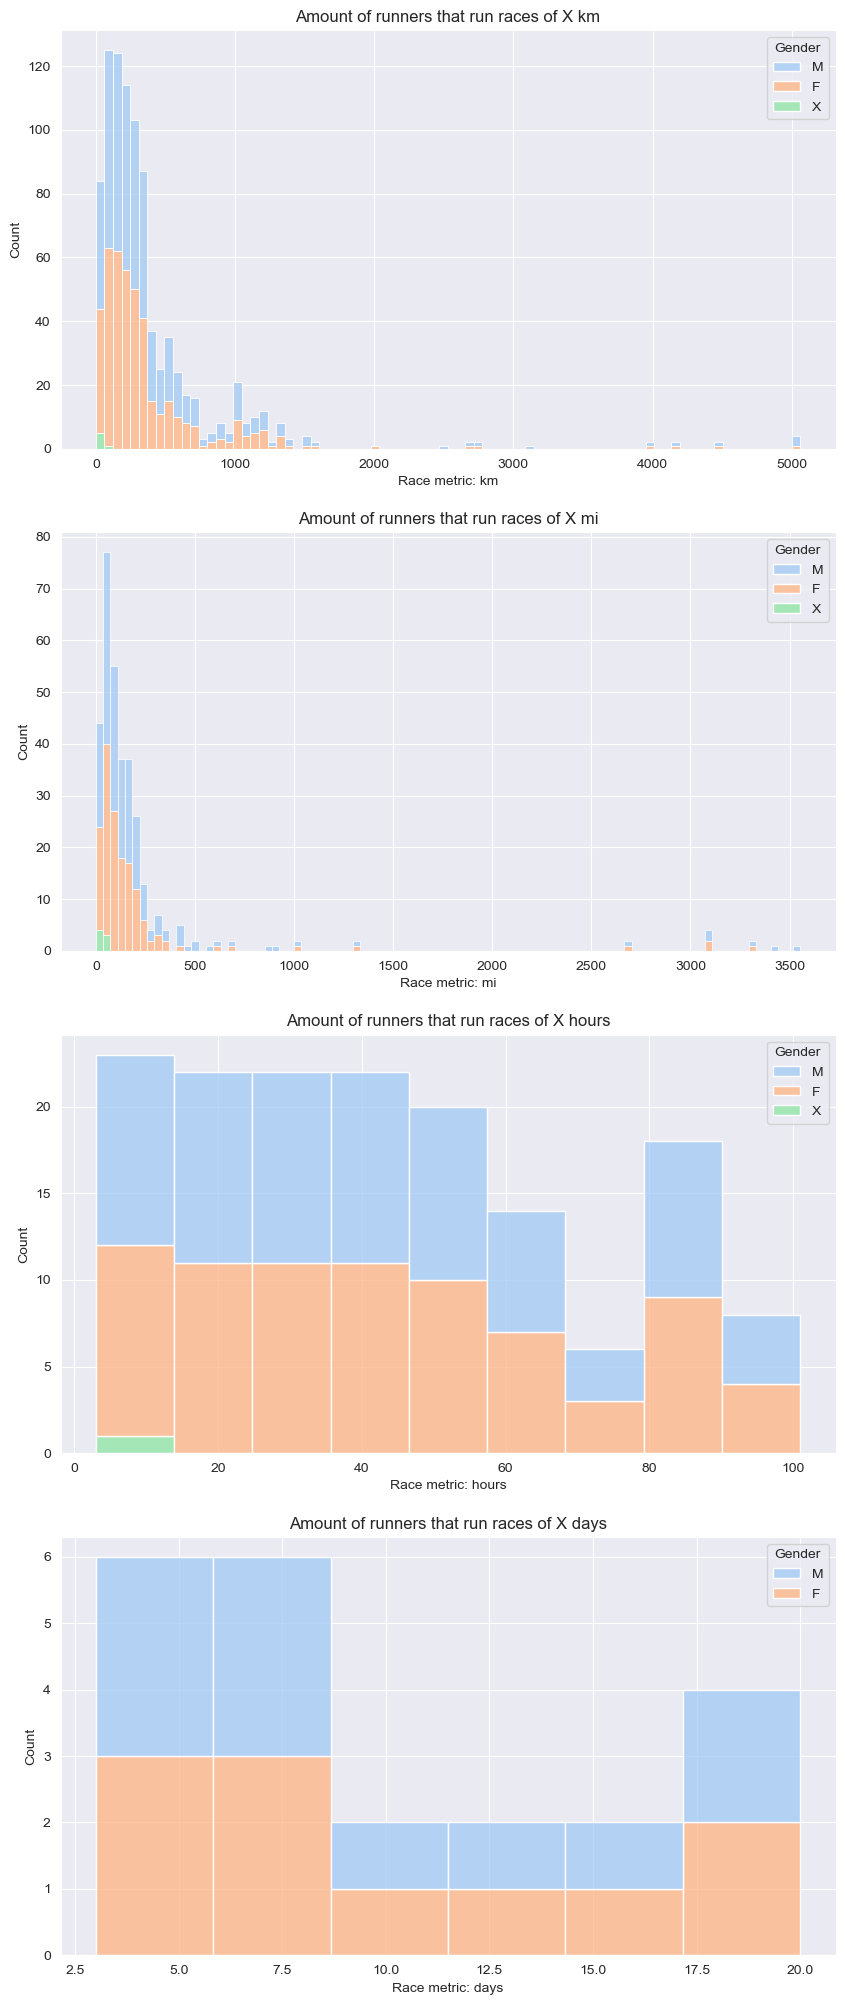

In [102]:
fig, ax = plt.subplots(4, 1, figsize=(10, 25))
sns.set_palette('pastel')
sns.set_style('darkgrid')
for metric, i in [
    ('km', 0),
    ('mi', 1),
    ('hours', 2),
    ('days', 3)
]:
    temp_df = df[['gender', 'distance_or_length', 'race_metric']
                 ][df['race_metric'] == metric].value_counts().reset_index()
    temp_df.columns = ['Gender', 'Distance', 'Metric', 'Count']

    sns.histplot(data=temp_df, x='Distance',
                 hue='Gender', multiple='stack', ax=ax[i])
    ax[i].set_title(f'Amount of runners that run races of X {metric}')
    ax[i].set_xlabel(f'Race metric: {metric}')
    
fig.savefig(f'{fig_path}count_of_runners_by_distance.jpg')

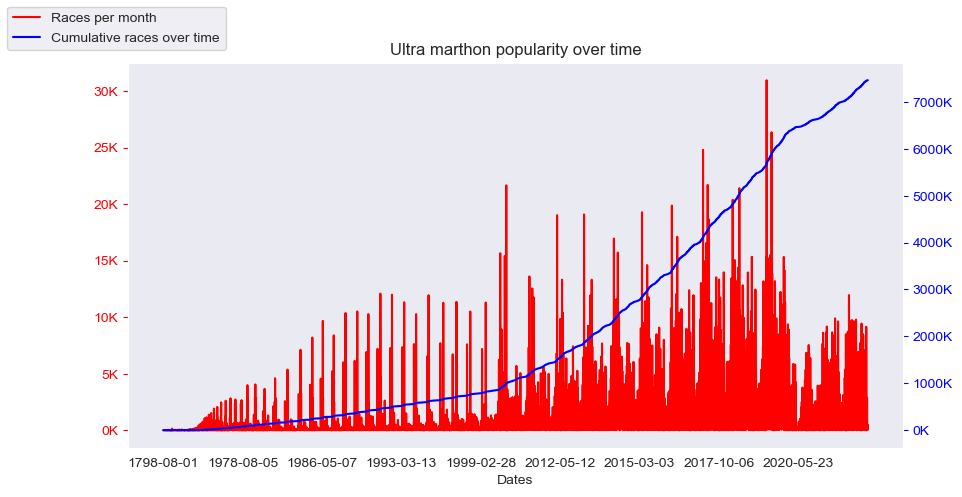

In [103]:
# Ultra marathon race popularity over time
fig, ax1 = plt.subplots(figsize = (10, 5))

dates_df = df['start_date'].value_counts().reset_index().sort_values(by = 'start_date', ascending = True)
dates_df['cumsum'] = dates_df['count'].cumsum()
races_per_day = df['start_date'].value_counts().sort_index()

ax1.plot(races_per_day.index, races_per_day, 'r-', label = 'Races per month')
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.set_title('Ultra marthon popularity over time')
ax1.set_xlabel('Dates')
ax1.set_ylabel('')
ax1.tick_params(colors = 'red', axis = 'y')
ax1.yaxis.set_major_formatter(lambda x, pos: '%1.0fK' % (x * 1e-3))
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(dates_df['start_date'], dates_df['cumsum'], 'b-', label = 'Cumulative races over time')
ax2.tick_params(colors = 'blue')
ax2.ticklabel_format(style = 'plain', axis = 'y')
ax2.yaxis.set_major_formatter(lambda x, pos: '%1.0fK' % (x * 1e-3))
ax2.grid(False)

plt.xticks(rotation = 45)
fig.legend(loc = 'upper left')

fig.savefig(f'{fig_path}ultras_popularity_over_time.jpg')

In [104]:
country_counts = df['athlete_country'].value_counts().reset_index()

def format_hover_text(val):
    if val >= 1e6:
        return f'{val / 1e6:.1f} M'
    elif val >= 1e3:
        return f'{val / 1e3:.1f} K'
    else:
        return f'{val}'
    
country_counts['formatted_vals'] = country_counts['count'].apply(format_hover_text)

fig = px.choropleth(
    country_counts,
    locations='athlete_country',
    color='count',
    hover_name='athlete_country',
    hover_data = {
        'count': False, 
        'formatted_vals': True, 
        'athlete_country': False
    },
    color_continuous_scale=px.colors.sequential.Plasma
)
for trace in fig.data:  
    trace.hovertemplate = '%{customdata[2]}: %{customdata[1]}<extra></extra>'
fig.write_image(f'{fig_path}athletes_per_county.jpg')
fig.show()

In [105]:
athlete_races = df[['athlete_id', 'gender', 'year_of_event', 'birth_year']].copy()
athlete_races['gender'] = athlete_races['gender'].astype('category')
athlete_races['race_age'] = athlete_races['year_of_event'] - athlete_races['birth_year']
race_counts = athlete_races['athlete_id'].value_counts()
athlete_races['race_count'] = athlete_races['athlete_id'].map(race_counts)
athlete_races.drop(columns = ['year_of_event', 'birth_year'], inplace = True)
proper_ages = athlete_races[(athlete_races['race_age'] < 95) & (athlete_races['race_age'] > 14)].copy().reset_index()

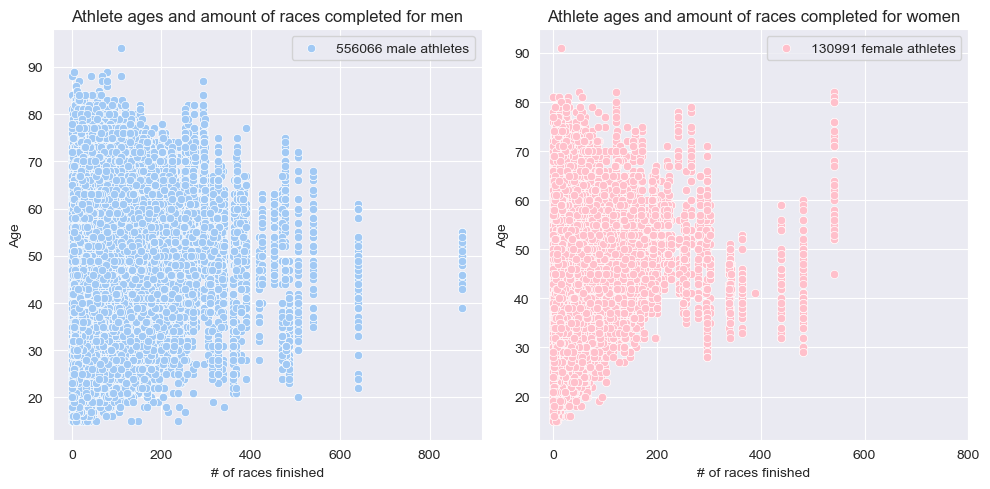

In [112]:
custom_ticks = [0, 200, 400, 600, 800]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

bin_m = proper_ages[proper_ages['gender'] == 'M'].sample(frac = 0.1)
bin_f = proper_ages[proper_ages['gender'] == 'F'].sample(frac = 0.1)

sns.scatterplot(data = bin_m, x = 'race_count', y = 'race_age', ax = ax[0])
ax[0].set_title(f'Athlete ages and amount of races completed for men')
ax[0].set_xlabel('# of races finished')
ax[0].set_ylabel('Age')
ax[0].set_xticks(ticks = custom_ticks, labels = custom_ticks)
ax[0].legend([f'{len(bin_m)} male athletes'])

sns.scatterplot(data = bin_f[bin_f['race_count'] < 1000], x = 'race_count', y = 'race_age', color = 'pink', ax = ax[1])
ax[1].set_title(f'Athlete ages and amount of races completed for women')
ax[1].set_xlabel('# of races finished')
ax[1].set_ylabel('Age')
ax[1].set_xticks(ticks = custom_ticks, labels = custom_ticks)
ax[1].legend([f'{len(bin_f)} female athletes'])
plt.tight_layout()
fig.savefig(f'{fig_path}athlete_ages_and_number_of_races_completed.jpg')

In [108]:
winners_male = df[df['gender'] == 'M'].sort_values(by = 'fastest_time', ascending = False).drop_duplicates(subset = 'event_name')
winners_female = df[df['gender'] == 'F'].sort_values(by = 'fastest_time', ascending = False).drop_duplicates(subset = 'event_name')
winners_male.head()

,year_of_event,event_name,distance_or_length,no_of_finishers,total_distance,athlete_club,athlete_country,birth_year,gender,age_category,average_speed,athlete_id,race_metric,start_date,end_date,fastest_time
3828751,2000,Sri Chinmoy Ultra Trio 700 Mile Race (USA),700.00,12,0.00,"Jamaica, NY",USA,1952,M,M45,4.70,219882,mi,2010-09-10,2010-09-23,9d 23:51:20
2937253,2021,The Last Annual Heart of the South Road Race (...,326.00,46,0.00,"Blacksburg, VA",USA,1977,M,M40,2.191,1202,mi,2021-06-17,2021-06-27,9d 23:25:57
3371218,2022,MilKil - 1000 km de France (FRA),1002.00,14,0.00,Unknown,FRA,1968,M,M50,4.187,18503,km,2022-06-12,2022-06-25,9d 23:17:40
3654613,1996,Nanango 1000 Mile Track Race - 1000km Split (AUS),1000.00,16,0.00,Unknown,CAN,1940,M,M55,4.18,1069846,km,1996-03-13,1996-03-29,9d 23:15:35
5815025,2013,Last Annual Vol-State 500K Endurance Run (USA),500.00,33,0.00,FL,USA,1965,M,M45,2.091,1386338,km,2013-07-11,2013-07-20,9d 23:08:40


In [109]:
winners_female.head()

,year_of_event,event_name,distance_or_length,no_of_finishers,total_distance,athlete_club,athlete_country,birth_year,gender,age_category,average_speed,athlete_id,race_metric,start_date,end_date,fastest_time
2463669,2019,"Across the Years, 10 days - 1000km Split (USA)",1000.00,5,0.00,"Seattle, WA",USA,1971,F,W45,4.174,11736,km,2019-12-28,2020-01-07,9d 23:33:16
2937252,2021,The Last Annual Heart of the South Road Race (...,326.00,46,0.00,"Newland, NC",USA,1982,F,W35,2.191,901860,mi,2021-06-17,2021-06-27,9d 23:25:26
2578723,2020,Last Annual Vol-State 500K Endurance Run (USA),500.00,50,0.00,Unknown,USA,1956,F,W60,2.089,818607,km,2020-07-09,2020-07-19,9d 23:18:14
3662035,1997,1000 Mile Stadium Run Odessa - 1000km Split (UKR),1000.00,2,0.00,Unknown,GER,1960,F,W35,4.19,76721,km,1997-10-05,1997-10-21,9d 22:52:11
3907544,2001,Sri Chinmoy Ultra Trio 700 Mile Race (USA),700.00,9,0.00,Melbourne,AUS,1958,F,W40,4.73,1066163,mi,2011-09-10,2011-09-23,9d 22:19:31


In [110]:
winner_val_cnt_M = winners_male['athlete_id'].value_counts().reset_index()
winner_val_cnt_F = winners_female['athlete_id'].value_counts().reset_index()
winner_val_cnt_F['idx'] = winner_val_cnt_F.index + 1
winner_val_cnt_M['idx'] = winner_val_cnt_M.index + 1
winner_val_cnt_M

,athlete_id,count,idx
0,21217,41,1
1,89417,33,2
2,13073,29,3
3,217355,24,4
4,236,24,5
...,...,...,...
22109,903785,1,22110
22110,386186,1,22111
22111,350095,1,22112
22112,570232,1,22113


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


'\nI need to properly align the tick marks on both plots\nI need to check out the plotted lines on both figures and find out if this is the way to properly display that data.\n'

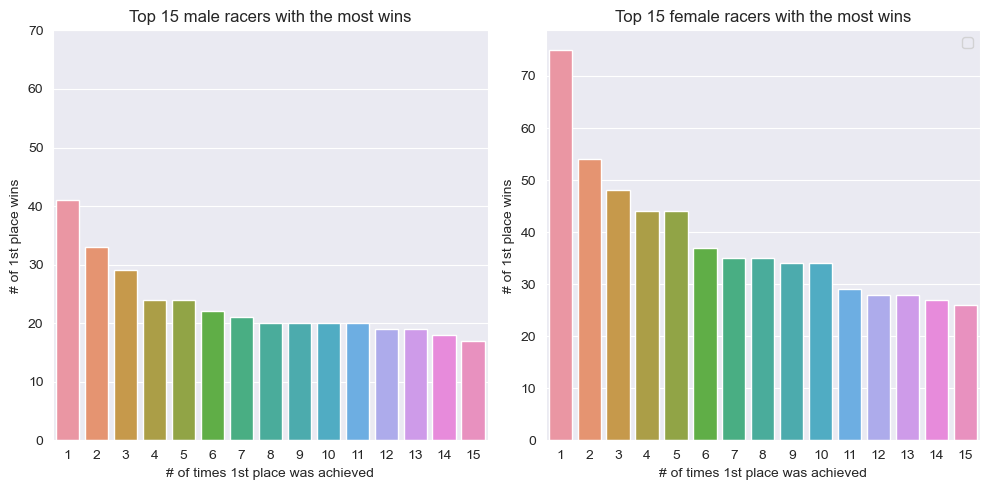

In [111]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.barplot(data = winner_val_cnt_M.head(15), x = 'idx', y = 'count', ax = ax[0])
sns.barplot(data = winner_val_cnt_F.head(15), x = 'idx', y = 'count', ax = ax[1])
ax[0].set_title('Top 15 male racers with the most wins')
ax[0].set_xlabel('# of times 1st place was achieved')
ax[0].set_ylabel('# of 1st place wins')
ax[0].set_yticks(np.arange(0, 71, 10))
ax[1].set_title('Top 15 female racers with the most wins')
ax[1].set_xlabel('# of times 1st place was achieved')
ax[1].set_ylabel('# of 1st place wins')
ax[1].set_yticks(np.arange(0, 71, 10))
plt.tight_layout()
'''
I need to properly align the tick marks on both plots
I need to check out the plotted lines on both figures and find out if this is the way to properly display that data.
'''

In [129]:
winners_overall_by_time = df[
    (df['fastest_time'].notna()) &
    (df['fastest_time'] > pd.to_timedelta(0, unit = 'm'))
].sort_values(by = 'fastest_time', ascending = True).drop_duplicates(subset = 'event_name')
winners_overall_by_time[winners_overall_by_time['gender'] == 'F']

,year_of_event,event_name,distance_or_length,no_of_finishers,total_distance,athlete_club,athlete_country,birth_year,gender,age_category,average_speed,athlete_id,race_metric,start_date,end_date,fastest_time
5516610,2012,Pass Mountain 50 km Race (USA),50.00,41,0.00,"Gilbert, AZ",USA,1974,F,W35,49.793,1341920,km,2012-11-10,2012-11-10,0 days 01:00:15
3010431,2021,Les 50km du Castellet (FRA),50.00,3,0.00,Unknown,KEN,1998,F,W23,16.645,916199,km,2021-10-21,2021-10-21,0 days 03:00:14
2819704,2021,50Km Nedbank Ultra Marathon Runified - women's...,50.00,22,0.00,Nedbank Running Club,RSA,1987,F,W23,16.269,665818,km,2021-05-23,2021-05-23,0 days 03:04:24
2581692,2020,Schleswiger Kreisbahn Marathon (GER),4.00,31,0.00,Kieler Eskalationsteam,GER,1986,F,W30,14.584,806475,km,2020-06-20,2020-06-20,0 days 03:10:54
7459157,1995,Redwood Empire 12 Hour Run - 50km Split (USA),50.00,1,0.00,Unknown,USA,1960,F,W23,14971.00,19566,km,1995-03-18,1995-03-18,0 days 03:20:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3703321,1997,Campeonato Int. 2000 kms Corriendo - 1000mi Sp...,1000.00,5,0.00,Unknown,MEX,1955,F,W40,4.31,1048259,mi,1997-03-02,1997-03-22,15 days 13:38:25
2558332,2020,Athens Int. Ultramarathon Festival - 1000 mile...,1000.00,1,0.00,Unknown,ROU,1977,F,W40,4.22,11922,mi,2020-01-16,2020-02-01,15 days 21:23:50
3703320,1997,Campeonato Int. 2000 kms Corriendo (MEX),2000.00,1,0.00,Unknown,MEX,1955,F,W40,4.26,1048259,km,1997-03-02,1997-03-22,19 days 13:38:25
2539010,2020,"Athens Int. Ultramarathon Festival - 2000 km, ...",1000.00,1,0.00,Unknown,GER,1944,F,W75,3.05,23288,mi,2020-02-02,2020-03-03,21 days 23:35:00


In [127]:
winners_overall_by_vol = df.sort_values(by = 'total_distance', ascending = False).drop_duplicates(subset = 'event_name')
winners_overall_by_vol[(winners_overall_by_vol['total_distance'] > 0) & (winners_overall_by_vol['gender'] == 'F')]

,year_of_event,event_name,distance_or_length,no_of_finishers,total_distance,athlete_club,athlete_country,birth_year,gender,age_category,average_speed,athlete_id,race_metric,start_date,end_date,fastest_time
2462947,2019,"Across the Years, 10 days (USA)",10.00,55,1192.16,Sydney,AUS,1972,F,W45,4.967,19644,days,2019-12-28,2020-01-07,0 days
3140586,2022,6 Days UMF Winter Edition - 1000 Km - 6d Split...,6.00,2,792.02,Unknown,FRA,1965,F,W55,5.5,86284,days,2022-03-10,2022-03-16,0 days
3974000,2002,Sri Chinmoy Ultra Trio 700 Mile Race - 6d Spli...,6.00,6,788.58,SCMT,AUT,1959,F,W40,5.48,82231,days,2012-09-16,2012-09-22,0 days
2463614,2019,"Across the Years, 10 days - 6d Split (USA)",6.00,51,758.80,Sydney,AUS,1972,F,W45,5.269,19644,days,2019-12-28,2020-01-07,0 days
2662994,2020,6 Days UMF - 10d (ITA),10.00,4,758.48,Unknown,ITA,1957,F,W60,3.16,28631,days,2020-09-07,2020-09-17,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975933,2019,Hill Climb Challenge: Round 1 - Beerburrum - 6...,6.00,1,46.20,Unknown,AUS,1988,F,W23,7.7,66329,hours,2019-03-23,2019-03-23,0 days
83589,2018,Fat Ass Clark 6h (PHI),6.00,1,46.20,Unknown,PHI,1988,F,W23,7.70,58368,hours,2018-01-06,2018-01-06,0 days
1871962,2019,The First Walk - 6h (HKG),6.00,1,46.00,Unknown,HKG,1964,F,W50,7.667,660787,hours,2019-01-01,2019-01-01,0 days
1612378,2017,Silverton 6 hour Challenge (USA),6.00,1,45.06,"San Francisco, CA",USA,1988,F,W23,7.51,165373,hours,2017-08-16,2017-08-16,0 days


In [116]:
df['event_name'].nunique()

26907